# CNN 实现 MINIST 手写数字识别

## 设置环境

In [16]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 保证每次运行py文件时，生成的随机数相同，结果可以复现
random_seed = 2 
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# 调用GPU
use_cuda = 1
torch.backends.cudnn.benchmark = True # 启用cudnn底层算法
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
print("Using device {}.".format(device))

Using device cuda.


## 下载并处理数据集

这里我们使用的是 MNIST 数据集，它是一个常用的手写数字识别数据集，包含了 60000 张训练图片和 10000 张测试图片，每张图片都是 28x28 像素。

以下代码会自动将数据集下载到目录下的 data 文件夹。

同时，我们对数据进行预处理，方便后续处理。

> 创建一个转换（Transformation）管道，该管道用于对图像进行预处理。
> 
> - `transforms.Compose()` 函数将多个转换组合在一起
> 
> - `transforms.ToTensor()` 将图片转换为 PyTorch 中处理的张量 `Tensor`
> 
> - `transforms.Normalize()` 对张量进行归一化，即减均值，除以标准差
> 
>   - 这里将张量标准化为均值为 0.1307，标准差为 0.3081 的正态分布，0.1307 和 0.3081 是 MNIST 数据集的全局平均值和标准偏差。
> 

In [17]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.1307,), std=(0.3081,))])
train_set = datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data/', train=False, download=True, transform=transform)

下载过程如下图所示：

![Alt text](img/downloading.png)

> 通过 `DataLoader`，以批次（`batch`）的形式加载数据，进行数据迭代和处理。
> 
> - `batch_size` 表示在训练过程中用于每个批次的样本数量。
>   当数据集很大时，无法一次性将所有数据加载到内存中进行训练，所以将数据划分为批次进行训练。每个批次将包含 `batch_size` 个样本。
> 
> - `shuffle=True` 表示在每个 `epoch` 开始时，数据会被重新打乱。
>   在训练过程中，如果不对数据进行打乱顺序，模型可能会受到样本顺序的影响，导致学习到特定的模式或顺序，进而影响模型的泛化能力。

In [18]:
# 设置超参数
batch_size_train = 100
batch_size_test = 1000
train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size_test, shuffle=True)

### 数据集可视化

打印部分数据：

In [19]:
examples = enumerate(test_loader) # 生成一个枚举对象, 里面包含了一个batch的数据
batch_idx, (example_data, example_targets) = next(examples)
print(f"一个batch的数据大小：{len(example_data)}\t"
      f"一个batch的数据形状(批次大小, 通道数, 图像高度, 图像宽度)：{example_data.shape}")
# 当前这个批次有 1000 个样本，每个样本是单通道的 28x28 像素的图像。
# 一个批次的tensor图像是一个形为 (B, C, H, W) 的张量。
print(example_targets)

一个batch的数据大小：1000	一个batch的数据形状(批次大小, 通道数, 图像高度, 图像宽度)：torch.Size([1000, 1, 28, 28])
tensor([2, 7, 4, 6, 1, 9, 8, 0, 2, 3, 6, 4, 9, 2, 5, 0, 3, 5, 4, 2, 1, 6, 2, 9,
        8, 2, 9, 8, 4, 1, 0, 4, 8, 5, 6, 8, 6, 2, 5, 8, 5, 7, 8, 6, 9, 2, 3, 6,
        2, 7, 8, 1, 7, 7, 6, 8, 7, 4, 3, 4, 7, 3, 7, 5, 4, 1, 2, 2, 5, 3, 8, 0,
        8, 3, 9, 7, 0, 8, 3, 2, 8, 9, 1, 0, 3, 7, 6, 6, 6, 1, 1, 7, 4, 8, 9, 4,
        3, 0, 6, 6, 9, 5, 2, 9, 1, 8, 0, 0, 5, 5, 1, 3, 4, 7, 1, 6, 1, 9, 5, 1,
        3, 1, 9, 7, 0, 6, 4, 9, 0, 5, 4, 6, 3, 7, 1, 4, 6, 7, 2, 3, 9, 2, 0, 0,
        5, 1, 7, 4, 0, 6, 7, 4, 6, 1, 8, 7, 2, 7, 9, 2, 8, 3, 5, 8, 9, 0, 0, 7,
        3, 8, 2, 8, 9, 7, 6, 5, 1, 9, 1, 9, 7, 8, 9, 1, 4, 1, 2, 0, 2, 0, 3, 3,
        8, 2, 3, 9, 7, 8, 8, 1, 6, 2, 8, 3, 7, 6, 0, 2, 1, 6, 9, 5, 8, 4, 4, 2,
        0, 8, 5, 8, 1, 7, 5, 4, 0, 2, 7, 1, 1, 5, 8, 2, 6, 2, 3, 1, 2, 3, 1, 0,
        2, 9, 8, 1, 1, 4, 0, 4, 7, 4, 2, 9, 9, 6, 4, 6, 0, 0, 7, 1, 3, 6, 0, 0,
        4, 5, 4, 8, 7, 9, 1, 9, 2, 7

![Alt text](img/show_batch.png)

查看数据集中的图片：

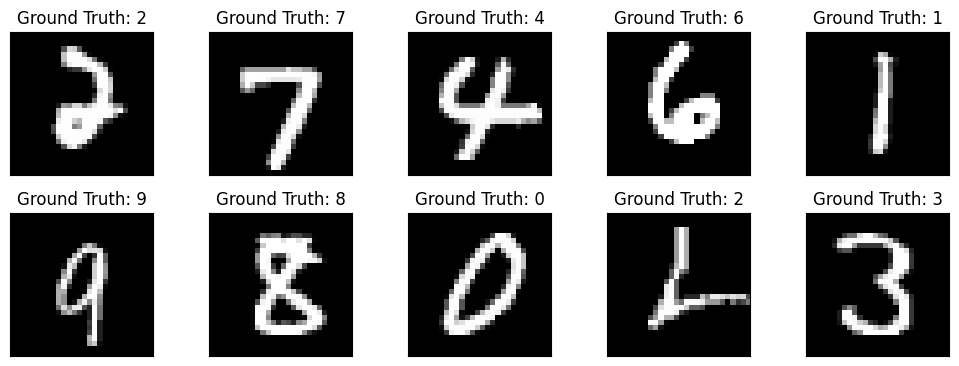

In [20]:
import matplotlib.pyplot as plt

# 若没有img文件夹，先创建一个
import os
if not os.path.exists('./img'):
    os.makedirs('./img')

fig = plt.figure(figsize=(10, 4), dpi=100)                              # 创建一个图像窗口，设置大小和分辨率
for i in range(10):
    plt.subplot(2, 5, i + 1)                                            # 2行5列, 第i+1个子图
    plt.tight_layout()                                                  # 自动调整子图参数, 使之填充整个图像区域
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')   # 画图，不插值；[i][0]表示第i个样本的第0个通道
    plt.title(f"Ground Truth: {example_targets[i]}")                    # 设置子图标题，真实值
    plt.xticks([])                                                      # 设置x轴刻度
    plt.yticks([])                                                      # 设置y轴刻度
plt.savefig('./img/test_set_example.png')                               # 保存图片
plt.show()

可以看到，数据集中的图片都是灰度图。图像标签为图片中手写数字的值，就是 0-9 这 10 个数字。

这些图片均由真人书写，包括字体大小、书写风格和线条粗细等丰富的信息，以确保这些图片的分布尽可能接近真实手写数字图片的分布，从而保证模型的泛化能力。

![Alt text](img/test_set_example.png)

## 构建模型

### 定义神经网络

这里我们通过 `torch.nn` 中的类来搭建一个包含卷积层、激活函数、池化层、全连接层的卷积神经网络。在结构上，我们将使用两个卷积层和两个全连接层，以及两层最大池化，使用 ReLUs 作为激活函数增加非线性、log_softmax 作为输出层的激活函数，并使用两个 dropout 层来防止过拟合。我们使用使用函数式 API 来构建网络，而不是使用 `nn.Sequential`，以便更灵活地定义前向传播函数。

网络结构图如下：

![module](img/module.svg)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义卷积层
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # 定义池化层（汇聚层）
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 定义 Dropout 层
        self.dropout = nn.Dropout(p=0.5)
        # 定义全连接层
        self.fc1 = nn.Linear(64 * 7 * 7, 300)
        self.fc2 = nn.Linear(300, 10)
    
    def forward(self, x):
        # 卷积层和池化层
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # 展平操作
        x = x.view(x.size(0),-1)
        # 全连接层
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        # 使用 log_softmax 作为输出层的激活函数
        return F.log_softmax(x, dim=1)

### 初始化网络

定义神经网络结构之后，将所有数据以batch的方式进行输入，通过网络层按照规则和参数进行计算，得到对应的网络输出，这就是前向传播。

通过打印输出的方式查看搭建好的网络的完整结构，使用torchsummary查看网络的顺序结构和参数：

In [40]:
network = Net() # 实例化网络
network = network.to(device) # 将网络移动到 GPU 上

from torchsummary import summary
summary(network, input_size=(1, 28, 28), batch_size=batch_size_train)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 32, 28, 28]             320
         MaxPool2d-2          [100, 32, 14, 14]               0
            Conv2d-3          [100, 64, 14, 14]          18,496
         MaxPool2d-4            [100, 64, 7, 7]               0
            Linear-5                 [100, 300]         941,100
           Dropout-6                 [100, 300]               0
            Linear-7                  [100, 10]           3,010
Total params: 962,926
Trainable params: 962,926
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.30
Forward/backward pass size (MB): 36.35
Params size (MB): 3.67
Estimated Total Size (MB): 40.33
----------------------------------------------------------------


## 模型训练

### 定义损失函数

损失函数是表示神经网络性能优劣的指标，表示当前的神经网络对监督数据在多大程度上不拟合。由于 MNIST 数据集的分类结果是 10 个类别，所以我们使用多分类问题的交叉熵损失函数来衡量预测结果和真实结果的差异。

由于 CrossEntropyLoss 函数包含 NLLloss、log、Softmax，而我们的网络最后一层是 log_softmax，所以我们直接使用 `F.nll_loss` 作为损失函数。
`F.nll_loss` 是负的 log 似然损失函数，它在 `log_softmax` 的输出上计算损失。

```python
output = network(data)
loss = F.nll_loss(output, target)
```

当计算出一次前向传播的损失之后，我们需要通过反向传播来计算梯度，然后更新网络参数。
PyTorch 中的 `loss.backward()` 函数用于反向传播计算梯度，`optimizer.step()` 函数用于更新参数。

```python
loss.backward() # 反向传播
optimizer.step() # 更新参数
```

### 定义优化器

使用 PyTorch 中的 optim 模块创建优化器对象，该优化器使用随机梯度下降（SGD）算法来更新神经网络中的参数。

> `lr` 是学习率（learning rate），代表着每次参数更新时的步长大小。
>
> `momentum` 是动量（momentum），是梯度下降算法的一种改进方式。

In [23]:
import torch.optim as optim

# 设置超参数
learning_rate = 0.01
momentum = 0.5
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

print(optimizer.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.01, 'momentum': 0.5, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}


### 训练函数

将一轮训练封装为函数。同时记录训练过程中的损失值，以便后续绘制曲线。

In [24]:
# 设置超参数
num_epochs = 15   # 训练轮数
log_interval = 6 # 每隔6个batch输出一次训练日志

train_set_len = len(train_loader.dataset) # type: ignore 训练集大小
train_losses  = [] # 记录训练损失
train_counter = [] # 记录训练的批次

def train(epoch, device=device):
    network.train() # 训练模式
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # 将数据移动到 GPU 上
        optimizer.zero_grad()               # 梯度清零
        output = network(data)              # 前向传播
        loss = F.nll_loss(output, target)   # 计算损失
        loss.backward()                     # 反向传播
        optimizer.step()                    # 更新参数
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{train_set_len} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

            # 保存训练模型
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')
            
            train_losses.append(loss.item()) # 记录训练损失
            train_counter.append((batch_idx * batch_size_train) + ((epoch - 1) * train_set_len)) # 记录训练的批次

## 模型测试

### 测试函数

In [25]:
test_set_len  = len(test_loader.dataset) # type: ignore 测试集大小
test_losses   = [] # 记录测试损失
test_counter  = [i*train_set_len for i in range(num_epochs + 1)] # 记录测试的批次

def test(device=device):
    network.eval() # 测试模式
    test_loss = 0
    correct = 0
    with torch.no_grad(): # 禁用梯度计算，节约内存
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # 将一批的损失相加
            pred = output.argmax(dim=1, keepdim=True) # 找到概率最大的下标
            correct += pred.eq(target.view_as(pred)).sum().item() # 计算正确的数量

    test_loss /= test_set_len
    test_losses.append(test_loss) # 记录测试损失
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{test_set_len} "
          f"({100. * correct / test_set_len:.2f}%)\n")

### 绘制训练曲线

In [26]:
# 多轮训练和测试
for epoch in range(1, num_epochs + 1):
    test()
    train(epoch)
test()


Test set: Average loss: 2.3087, Accuracy: 834/10000 (8.34%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.318580
Train Epoch: 1 [600/60000 (1%)]	Loss: 2.262211
Train Epoch: 1 [1200/60000 (2%)]	Loss: 2.236151
Train Epoch: 1 [1800/60000 (3%)]	Loss: 2.199580
Train Epoch: 1 [2400/60000 (4%)]	Loss: 2.164172
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.069191
Train Epoch: 1 [3600/60000 (6%)]	Loss: 2.043109
Train Epoch: 1 [4200/60000 (7%)]	Loss: 1.904186
Train Epoch: 1 [4800/60000 (8%)]	Loss: 1.771430
Train Epoch: 1 [5400/60000 (9%)]	Loss: 1.666909
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.370355
Train Epoch: 1 [6600/60000 (11%)]	Loss: 1.211149
Train Epoch: 1 [7200/60000 (12%)]	Loss: 1.101723
Train Epoch: 1 [7800/60000 (13%)]	Loss: 0.948880
Train Epoch: 1 [8400/60000 (14%)]	Loss: 0.805685
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.777226
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.726039
Train Epoch: 1 [10200/60000 (17%)]	Loss: 0.661514
Train Epoch: 1 [10800/60000 (18%)]	Loss: 0.730944
Train Epoch: 1 [114

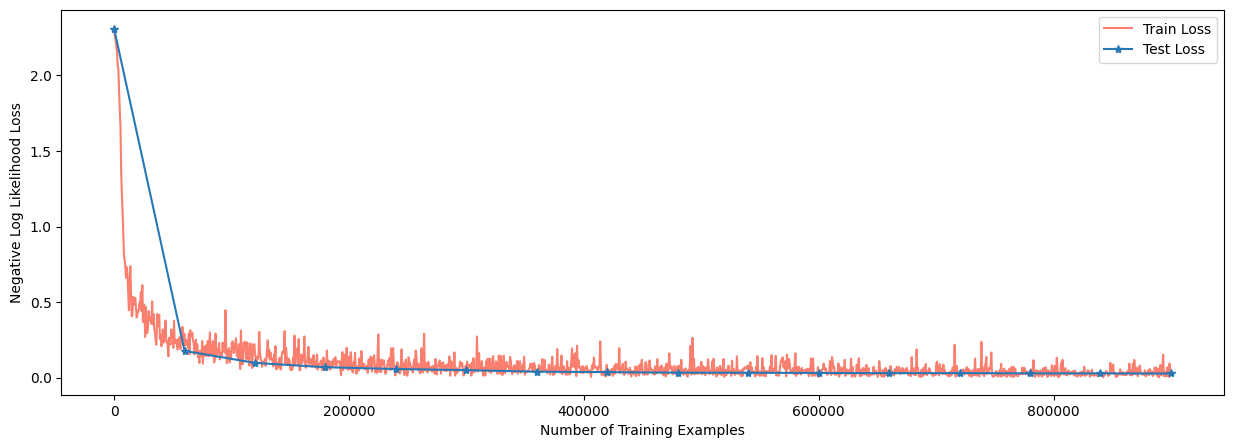

In [27]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.plot(train_counter, train_losses, color='#fa7f6f')
plt.plot(test_counter, test_losses, color='#2878b5', marker='*')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Number of Training Examples')
plt.ylabel('Negative Log Likelihood Loss')
plt.savefig('./img/loss.png')
plt.show()